## Import Fight Data and Merge with Hometown Data

In [216]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

fight_data_file = '../combined_data/combined_fight_data.csv'

def import_and_merge():
    fight_data = pd.read_csv(fight_data_file)
    
    #Add Blue and Red win columns
    fight_data['B_Winner'] = [1 if x=='Blue' else 0 for x in fight_data['Winner']]
    fight_data['R_Winner'] = [1 if x=='Red' else 0 for x in fight_data['Winner']]
    
    #Drop columns irrelevant to this prediction
    fight_data = fight_data.drop(columns=['Referee', 'no_of_rounds', 'Winner', 'date', 'end_method', 'end_how', 
                                          'end_round', 'attendance'])
    print('Fight Data Stats: ')
    print('Shape: ', fight_data.shape)
    #display(fight_data)
    
    #Separate fight data into individual fighter stats
    blue_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^R_', col)==None]]
    blue_fighters = blue_fighters.rename(columns=lambda x: re.sub('^B_', '', x))
    print('\nBlue fighter Stats: ')
    print('Shape: ', blue_fighters.shape)
    #display(blue_fighters)
    
    red_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^B_', col)==None]]
    red_fighters = red_fighters.rename(columns=lambda x: re.sub('^R_', '', x))
    print('\nRed fighter Stats: ')
    print('Shape: ', red_fighters.shape)
    #display(red_fighters)
    
    #Concatenate blue and red fighter stats
    fighters_data = pd.concat([blue_fighters, red_fighters], ignore_index=True)
    fighters_data = fighters_data.rename(columns={'total_time_fought(seconds)':'total_time_fought_seconds'})
    fighters_data = fighters_data.drop(columns='fighter')
    print('\nTotal fighter Stats: ')
    print('Shape: ', fighters_data.shape)
    
    # Create df without offence stats
    fighters_no_offence_stats = fighters_data.drop(columns=[col for col in fighters_data.columns if re.search('^avg_', col) != None])
    fighters_no_offence_stats = fighters_no_offence_stats.drop(columns='total_time_fought_seconds')
    print('\nFighters no offensive stats: ')
    print('Shape: ', fighters_no_offence_stats.shape)
    
    return (fighters_no_offence_stats, fighters_data)
    
data_no_offence_stats, data  = import_and_merge()

Fight Data Stats: 
Shape:  (5062, 147)

Blue fighter Stats: 
Shape:  (5062, 76)

Red fighter Stats: 
Shape:  (5062, 76)

Total fighter Stats: 
Shape:  (10124, 75)

Fighters no offensive stats: 
Shape:  (10124, 26)



# Data cleaning and model selection
- Separate location and home town into city and country
- Categorize weight_class, title_bout, Stance, and locations
- Convert elevation data into numeric data
- Tune parameters
- Visualize model performance

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score


def plot_missing_vals(df):
    columns = []
    nans_per_col = []
    
    for col in df.columns:
        num_nans = sum(pd.isnull(df[col]))
        #print('Num of NaNs in col ', col, ': ', num_nans)
        columns.append(col)
        nans_per_col.append(num_nans)
    
    print('Shape: ', df.shape)
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    ax.bar(columns, nans_per_col)
    plt.xticks(rotation='vertical')
    plt.ylabel('# NaNs')
    plt.title('Number of missing data per feature')
    
def inspect_data(fighter_df):
    # Display missing value numbers in fighter data
    print('\nBefore dropping fightres with no offence/defence stats')
    plot_missing_vals(fighter_df)
    
    #Fighter age, weight, height, and reach distribution
    hrw_attrs_df = pd.DataFrame(fighter_df[['Height_cms', 'Reach_cms', 'Weight_lbs']])    
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes()
    hrw_attrs_df.boxplot()
    plt.title('Height, Reach and weight dsitributions')
    plt.ylim([100, 250])
    
    age_df = pd.DataFrame(fighter_df[['age']])   
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes()
    age_df.boxplot()
    plt.title('Age dsitributions')
       

def clean_data(fighter_df):    
   #Fill missing values for height, reach, weight, age
    weight_class_means = {}
    weight_classes = np.unique(fighter_df['weight_class'])
    for weight_class in weight_classes:
        weight_class_idx = fighter_df['weight_class'] == weight_class
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Height_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Height_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Height_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Reach_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Reach_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Reach_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Weight_lbs']), weight_class_idx)
        fighter_df.loc[null_idx, 'Weight_lbs'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Weight_lbs'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['age']), weight_class_idx)
        fighter_df.loc[null_idx, 'age'] = np.nanmean(fighter_df.loc[weight_class_idx, 'age'])
    
    # Fill out missing stance
    fighter_df.loc[pd.isnull(fighter_df['Stance']), 'Stance'] = 'Orthodox'
    
    # Ger rid of fights without location
    fighter_df = fighter_df.loc[~pd.isnull(fighter_df['city']), :]
    
    # Fill missing elevations with 0
    fighter_df.loc[pd.isnull(fighter_df['location_elevation']), 'location_elevation'] = 0
    fighter_df.loc[pd.isnull(fighter_df['home_elevation']), 'home_elevation'] = 0
    
    # Replacet title bout with actual numbers
    fighter_df.loc[fighter_df['title_bout'] == 'True', 'title_bout'] = 1
    fighter_df.loc[fighter_df['title_bout'] == 'False', 'title_bout'] = 0
    
    #Drop rows with too many missing values
    if 'avg_BODY_att' in fighter_df.columns:
        fighter_df = fighter_df.loc[~pd.isnull(fighter_df['avg_BODY_att']), :]    
        
    return fighter_df

def structure_data(fighter_df):   
    # Split Locations  and hometowns into city and country
    if 'location' in fighter_df.columns:
        fighter_df['city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['location']]
        fighter_df['country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['location']]
        fighter_df = fighter_df.drop(columns='location')
    
    if 'hometown' in fighter_df.columns:
        #First get rid of data with nan hometowns
        fighter_df['hometown_city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['hometown']]
        fighter_df['hometown_country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['hometown']]
        fighter_df.drop(columns='hometown')
        
    return fighter_df
    

def compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels): # Receives already scales
    train_accuracy_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    accuracy_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    precision_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    recall_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    f1_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    
    idx = 0;
    kf = KFold(n_splits=20)
    
    for train_index, test_index in kf.split(features):
        X_train_scaled, X_test_scaled = features.iloc[train_index, :], features.iloc[test_index, :]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        #Models
        knn = KNeighborsClassifier(**knn_params).fit(X_train_scaled, y_train)    
        lr = LogisticRegression(**lr_params).fit(X_train_scaled, y_train)  
        svc = LinearSVC(**svc_params).fit(X_train_scaled, y_train)
        n_bayes = BernoulliNB(**nbayes_params).fit(X_train_scaled, y_train)
        random_forest = RandomForestClassifier(n_estimators=50, **rforest_params).fit(X_train_scaled, y_train)
        
        #Update tables
        train_accuracy_df.loc[idx] = [knn.score(X_train_scaled, y_train), lr.score(X_train_scaled, y_train), svc.score(X_train_scaled, y_train), 
                                n_bayes.score(X_train_scaled, y_train), random_forest.score(X_train_scaled, y_train)]
        
        accuracy_df.loc[idx] = [knn.score(X_test_scaled, y_test), lr.score(X_test_scaled, y_test), svc.score(X_test_scaled, y_test), 
                                n_bayes.score(X_test_scaled, y_test), random_forest.score(X_test_scaled, y_test)]

        precision_df.loc[idx] = [precision_score(y_test, knn.predict(X_test_scaled)), precision_score(y_test, lr.predict(X_test_scaled)), 
                                 precision_score(y_test, svc.predict(X_test_scaled)), precision_score(y_test, n_bayes.predict(X_test_scaled)),
                                 precision_score(y_test, random_forest.predict(X_test_scaled))]

        recall_df.loc[idx] = [recall_score(y_test, knn.predict(X_test_scaled)), recall_score(y_test, lr.predict(X_test_scaled)), 
                              recall_score(y_test, svc.predict(X_test_scaled)), recall_score(y_test, n_bayes.predict(X_test_scaled)),
                              recall_score(y_test, random_forest.predict(X_test_scaled))]

        f1_df.loc[idx] = [f1_score(y_test, knn.predict(X_test_scaled)), f1_score(y_test, lr.predict(X_test_scaled)), 
                          f1_score(y_test, svc.predict(X_test_scaled)), f1_score(y_test, n_bayes.predict(X_test_scaled)),
                          f1_score(y_test, random_forest.predict(X_test_scaled))]
        idx += 1
        
    #Display results
    display('------Train accuracy score:-------', train_accuracy_df.median())
    display('------Median accuracy score:-------', accuracy_df.median())
    display('------Median precision score:------', precision_df.median())
    display('------Median recall score:---------', recall_df.median())
    display('------Median F1 score:-------------', f1_df.median())
    
    fig = plt.figure(figsize=(15, 7))
    train_accuracy_df.drop(columns='SVC').boxplot()
    plt.title('Train Accuracy scores')
    plt.ylabel('Score')
    
    fig = plt.figure(figsize=(15, 7))
    accuracy_df.drop(columns='SVC').boxplot()
    plt.title('Accuracy scores')
    plt.ylabel('Score')
     
    fig = plt.figure(figsize=(15, 7))       
    precision_df.drop(columns='SVC').boxplot()
    plt.title('Precision score')
    plt.ylabel('Score')
    
    fig = plt.figure(figsize=(15, 7))        
    recall_df.drop(columns='SVC').boxplot()
    plt.title('Recall score')
    plt.ylabel('Score')

    fig = plt.figure(figsize=(15, 7))        
    f1_df.drop(columns='SVC').boxplot()
    plt.title('F1 score')
    plt.ylabel('Score')
    
    
def parameter_tuning(df, scale):
    df = structure_data(df)
    df = clean_data(df)
    dummy_df = pd.get_dummies(df)
    
    labels = dummy_df['Winner']
    features = dummy_df.drop(columns=['Winner'])
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state=0, stratify=labels)
    
    #Scale
    if scale:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    
    # Search for best parameters
    knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
    knn_tuner = GridSearchCV(knn, param_grid={'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'n_neighbors':list(range(1,51))}).fit(X_train_scaled, y_train)
    print('KNN Best params:', knn_tuner.best_params_ )
    
    lr = LogisticRegression().fit(X_train_scaled, y_train)
    lr_tuner =  GridSearchCV(lr, param_grid={'solver':['newton-cg', 'lbfgs', 'liblinear'], 'C':list(np.linspace(0.001,20,40))}).fit(X_train_scaled, y_train)
    print('LR Best params:', lr_tuner.best_params_)
    
    svc = LinearSVC().fit(X_train_scaled, y_train)
    svc_tuner = GridSearchCV(svc, param_grid={'C':list(np.linspace(0.0000000001, 0.15, 50))}).fit(X_train_scaled, y_train)
    print('SVC Best params:', svc_tuner.best_params_)
    
    n_bayes = BernoulliNB().fit(X_train_scaled, y_train)
    nbayes_tuner = GridSearchCV(n_bayes, param_grid={'alpha':list(np.linspace(0.0000000001, 21, 50))}).fit(X_train_scaled, y_train)
    print('NaiveBayes Best params:', nbayes_tuner.best_params_)
    
    random_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
    rforest_tuner = GridSearchCV(random_forest, param_grid={'max_features':['auto', 'sqrt', 'log2'], 'max_depth':list(np.linspace(1,30,50)), 'min_samples_split':list(range(2,30))}).fit(X_train_scaled, y_train)
    print('RandomForest Best params:', rforest_tuner.best_params_)
    
    # Compare models with tuned parameters
    compare_models( knn_tuner.best_params_, lr_tuner.best_params_, svc_tuner.best_params_, nbayes_tuner.best_params_, rforest_tuner.best_params_, features, labels)
    
    return(knn_tuner.best_params_, lr_tuner.best_params_, svc_tuner.best_params_, nbayes_tuner.best_params_, rforest_tuner.best_params_, features, labels)
    


In [ ]:
# Compare models for Data with no offensive stats
knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels = parameter_tuning(data_no_offence_stats, False)

In [ ]:
# Compare models for data with offensive stats
knn_params_offence, lr_params_offence, svc_params_offence, nbayes_params_offence, rforest_params_offence, features_offence, labels_offence = parameter_tuning(data, False)

KNN Best params: {'algorithm': 'auto', 'n_neighbors': 15}
LR Best params: {'C': 0.001, 'solver': 'liblinear'}
SVC Best params: {'C': 0.05204081639183673}
NaiveBayes Best params: {'alpha': 14.571428571459185}


In [202]:
# Tuned Parameters Obtaineds
def evaluate_models_best_params_no_offence(data):
    data['Winner'] = data_no_offence_stats['Winner'].copy()
    knn_params =  {'algorithm': 'auto', 'n_neighbors': 19}
    lr_params = {'C': 0.001, 'solver': 'newton-cg'}
    svc_params = {'C': 0.11326530614693876}
    nbayes_params =  {'alpha': 12.428571428612246}
    rforest_params = {'max_depth': 7.5102040816326525, 'max_features': 'auto', 'min_samples_split': 4}
    dummy_df = pd.get_dummies(data)

    labels = dummy_df['Winner']
    features = dummy_df.drop(columns=['Winner'])
    compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels)

#Parameters for data with offence stats
def evaluate_models_best_params(clean_data):
    clean_data['Winner'] = data['Winner'].copy()
    knn_params = {'algorithm': 'auto', 'n_neighbors': 15}
    lr_params = {'C': 0.001, 'solver': 'liblinear'}
    svc_params = {'C': 0.05204081639183673}
    nbayes_params = {'alpha': 14.571428571459185}
    rforest_params = {'max_depth': 10.46938775510204, 'max_features': 'auto', 'min_samples_split': 18}
    dummy_df = pd.get_dummies(clean_data)

    labels = dummy_df['Winner']
    features = dummy_df.drop(columns=['Winner'])
    compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels)
    

************ALL FEATURES**************

No offence stats


'------Train accuracy score:-------'

KNN                    0.606633
Logistic Regression    0.559906
SVC                    0.507628
Naive Bayes            0.539415
Random Forest          0.615673
dtype: float64

'------Median accuracy score:-------'

KNN                    0.494071
Logistic Regression    0.534653
SVC                    0.488628
Naive Bayes            0.491600
Random Forest          0.502970
dtype: float64

'------Median precision score:------'

KNN                    0.480955
Logistic Regression    0.541302
SVC                    0.489473
Naive Bayes            0.497807
Random Forest          0.503962
dtype: float64

'------Median recall score:---------'

KNN                    0.511361
Logistic Regression    0.502417
SVC                    0.271555
Naive Bayes            0.618935
Random Forest          0.543367
dtype: float64

'------Median F1 score:-------------'

KNN                    0.497423
Logistic Regression    0.524261
SVC                    0.362882
Naive Bayes            0.509812
Random Forest          0.519511
dtype: float64



Offence stats


'------Train accuracy score:-------'

KNN                    0.618332
Logistic Regression    0.583024
SVC                    0.514487
Naive Bayes            0.543460
Random Forest          0.812472
dtype: float64

'------Median accuracy score:-------'

KNN                    0.503041
Logistic Regression    0.557715
SVC                    0.532203
Naive Bayes            0.476886
Random Forest          0.526123
dtype: float64

'------Median precision score:------'

KNN                    0.533756
Logistic Regression    0.624483
SVC                    0.538929
Naive Bayes            0.521439
Random Forest          0.574645
dtype: float64

'------Median recall score:---------'

KNN                    0.553478
Logistic Regression    0.570399
SVC                    0.850861
Naive Bayes            0.608863
Random Forest          0.575825
dtype: float64

'------Median F1 score:-------------'

KNN                    0.528299
Logistic Regression    0.564752
SVC                    0.597877
Naive Bayes            0.547660
Random Forest          0.536644
dtype: float64

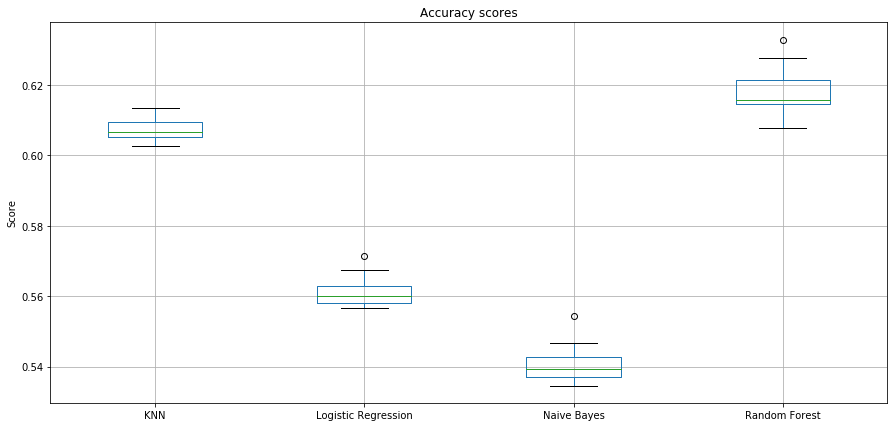

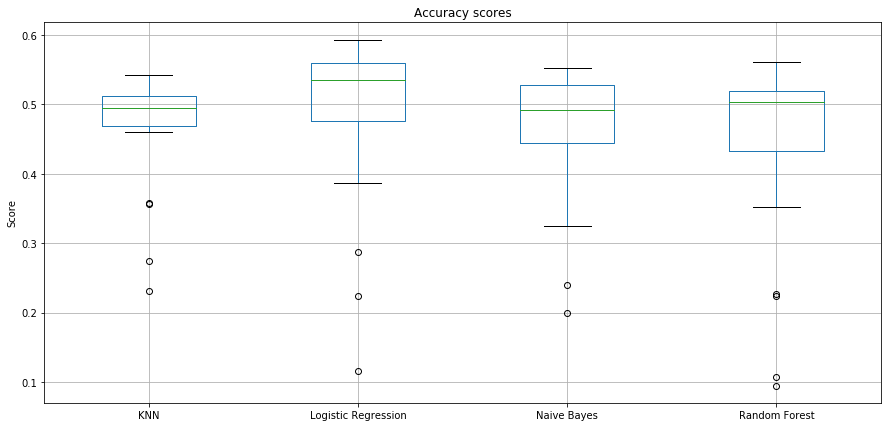

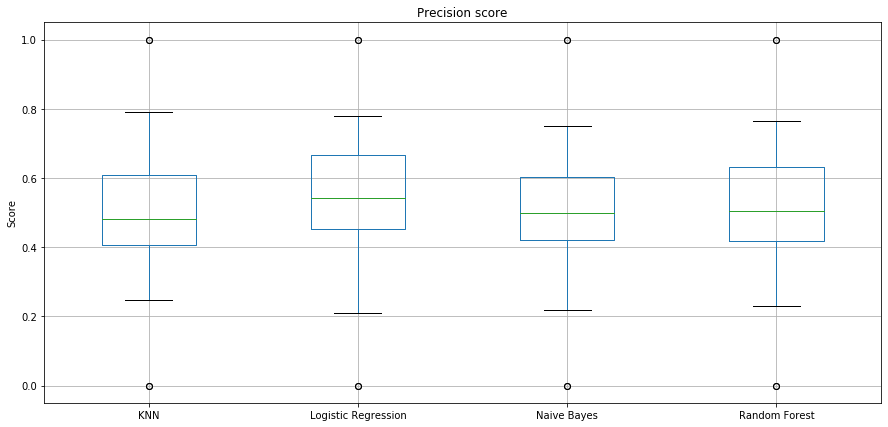

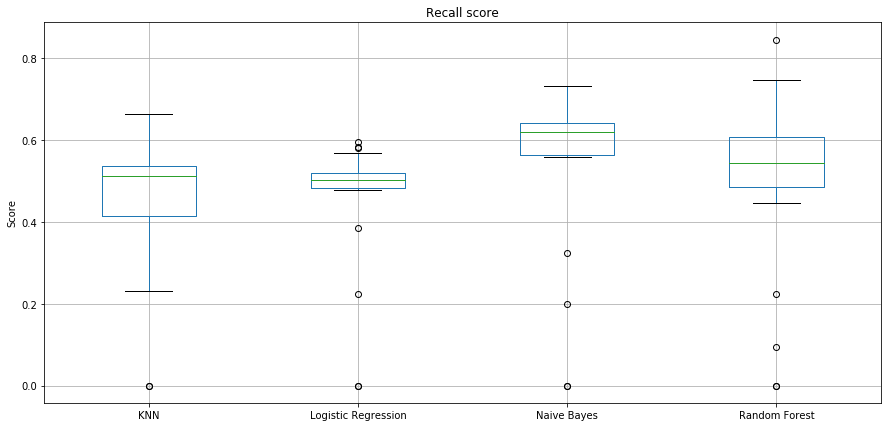

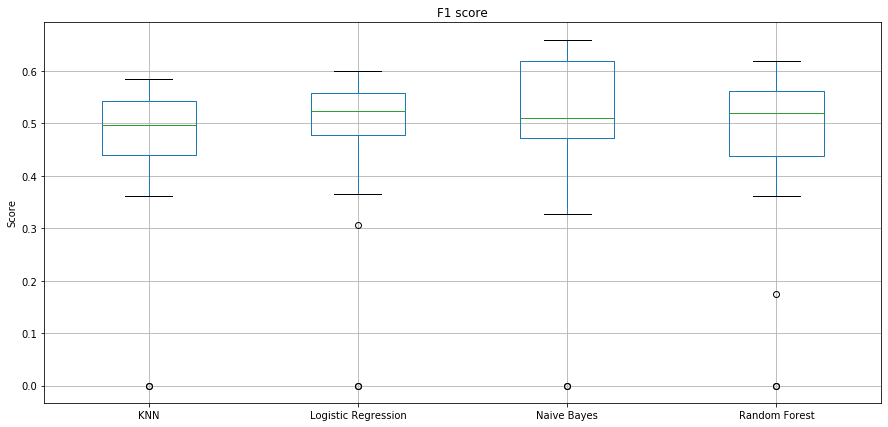

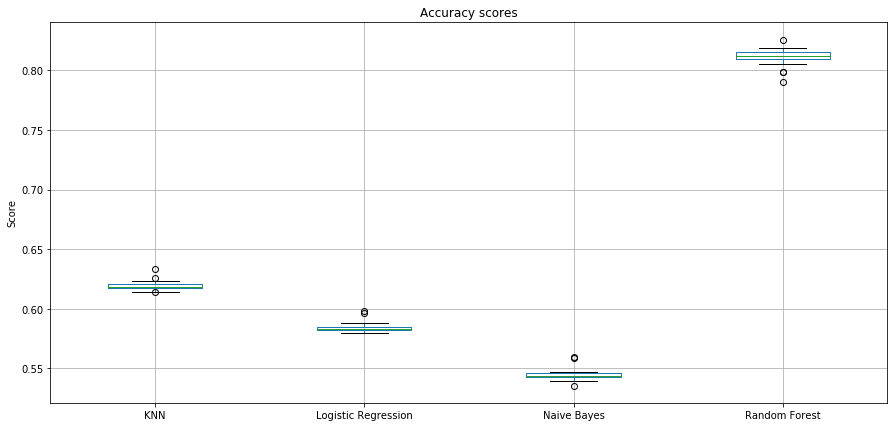

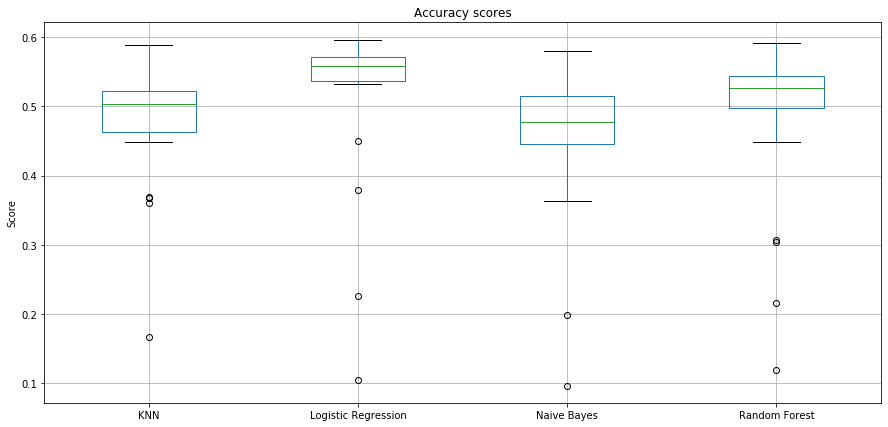

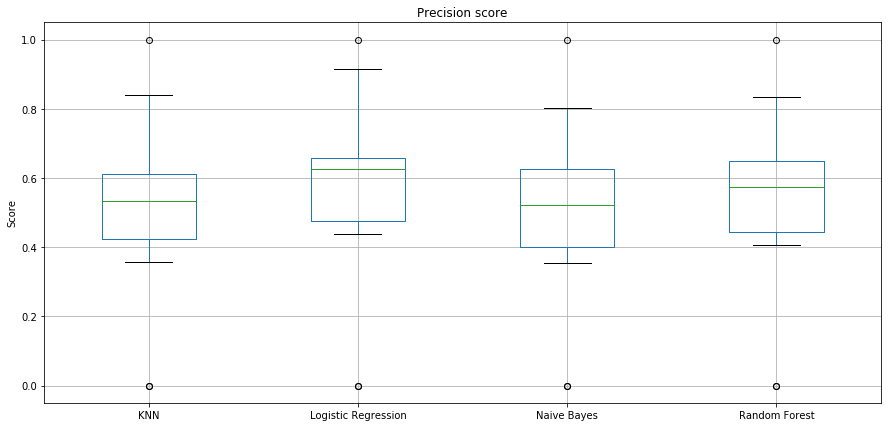

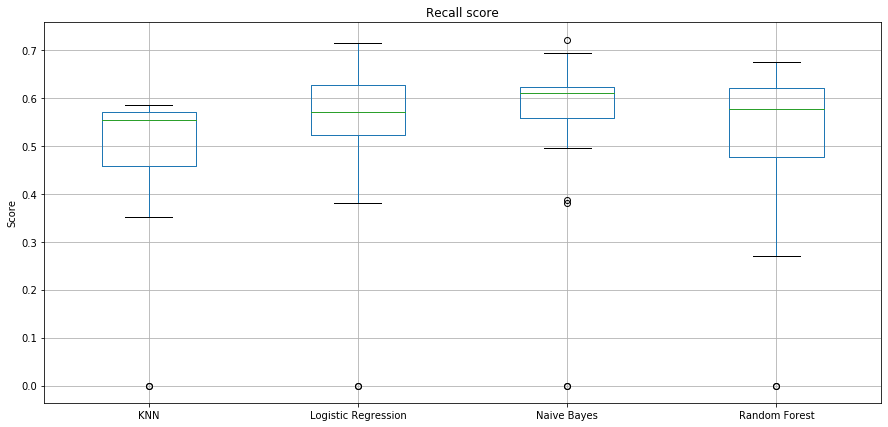

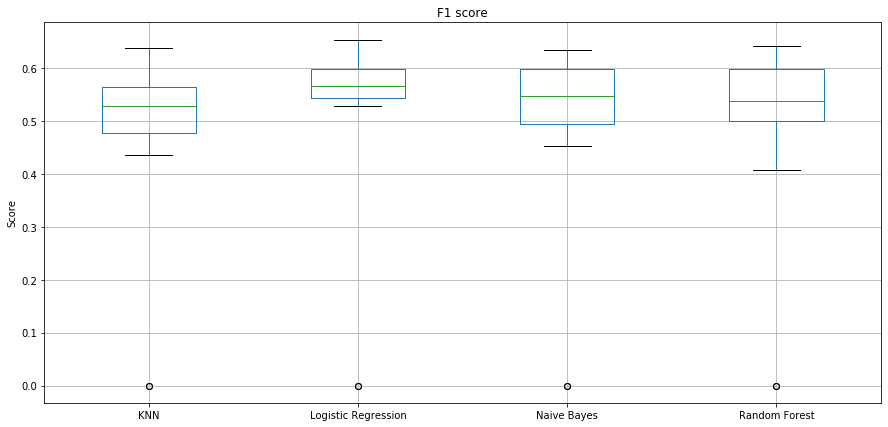

In [195]:
# Explore correlation and find best correlated features
def plot_correlation(data_no_offence_stats):
    df = data_no_offence_stats.drop(columns=['city', 'country', 'weight_class'])

    corr = df.corr()['Winner'][:]
    corr = corr.drop(['Winner']) * 100
    corr = corr.loc[~pd.isnull(corr)]
    corr = abs(corr).sort_values()

    most_corr_features = corr.index[-int(len(corr)/2):]
    return list(most_corr_features)

data_no_offence_stats = clean_data(data_no_offence_stats)
data = clean_data(data)

most_corr_features_no_offence = plot_correlation(data_no_offence_stats)
most_corr_features = plot_correlation(data)

data_no_offence_stats = structure_data(data_no_offence_stats)
data = structure_data(data)

#See if models improve with most correlated features
print('************ALL FEATURES**************')
print('\nNo offence stats')
evaluate_models_best_params_no_offence(data_no_offence_stats.copy())
print('\n\nOffence stats')
evaluate_models_best_params(data.copy())



*****TOP CORRELATED FEATURES ONLY********

No offence stats


'------Train accuracy score:-------'

KNN                    0.591981
Logistic Regression    0.554098
SVC                    0.556574
Naive Bayes            0.532858
Random Forest          0.600625
dtype: float64

'------Median accuracy score:-------'

KNN                    0.515810
Logistic Regression    0.524752
SVC                    0.544020
Naive Bayes            0.527668
Random Forest          0.526214
dtype: float64

'------Median precision score:------'

KNN                    0.516918
Logistic Regression    0.541335
SVC                    0.551644
Naive Bayes            0.509542
Random Forest          0.549166
dtype: float64

'------Median recall score:---------'

KNN                    0.501092
Logistic Regression    0.505931
SVC                    0.506653
Naive Bayes            0.645871
Random Forest          0.483996
dtype: float64

'------Median F1 score:-------------'

KNN                    0.502964
Logistic Regression    0.525417
SVC                    0.516456
Naive Bayes            0.593189
Random Forest          0.481713
dtype: float64



Offence stats


'------Train accuracy score:-------'

KNN                    0.629334
Logistic Regression    0.570259
SVC                    0.518419
Naive Bayes            0.534792
Random Forest          0.816193
dtype: float64

'------Median accuracy score:-------'

KNN                    0.521845
Logistic Regression    0.547994
SVC                    0.566219
Naive Bayes            0.513350
Random Forest          0.535844
dtype: float64

'------Median precision score:------'

KNN                    0.560944
Logistic Regression    0.610972
SVC                    0.514292
Naive Bayes            0.554886
Random Forest          0.603054
dtype: float64

'------Median recall score:---------'

KNN                    0.554436
Logistic Regression    0.569906
SVC                    0.930567
Naive Bayes            0.593447
Random Forest          0.583619
dtype: float64

'------Median F1 score:-------------'

KNN                    0.551179
Logistic Regression    0.547361
SVC                    0.616375
Naive Bayes            0.575277
Random Forest          0.550787
dtype: float64

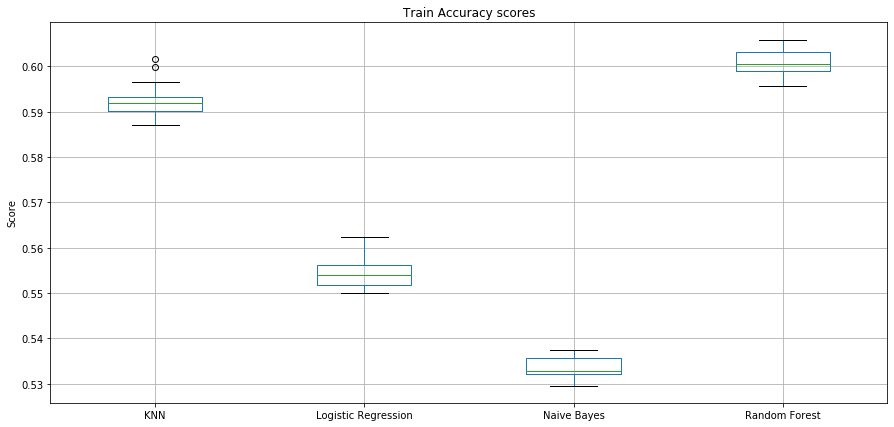

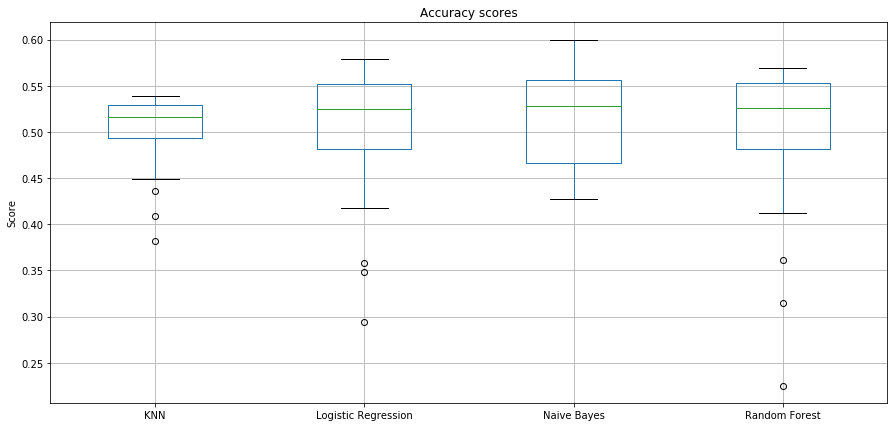

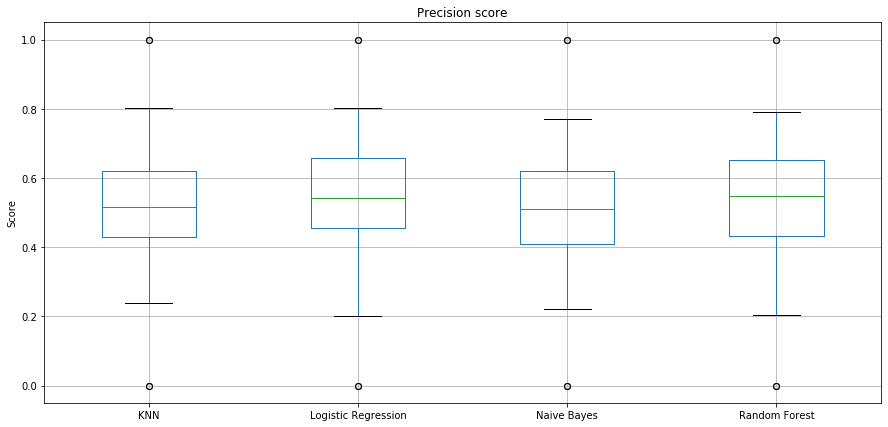

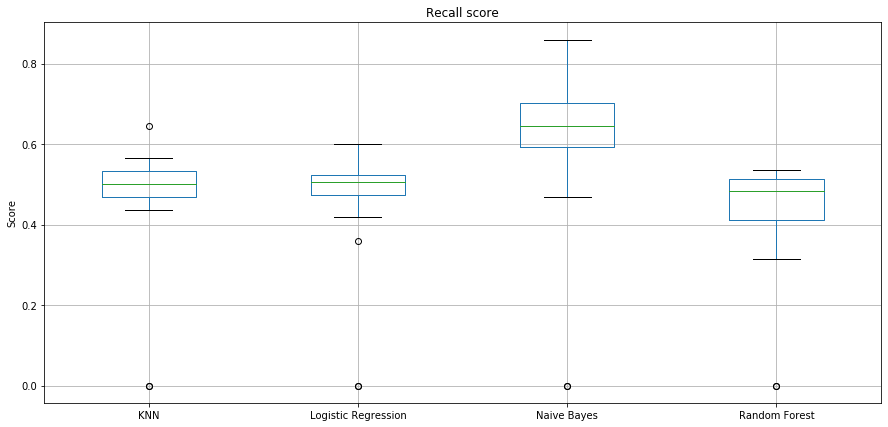

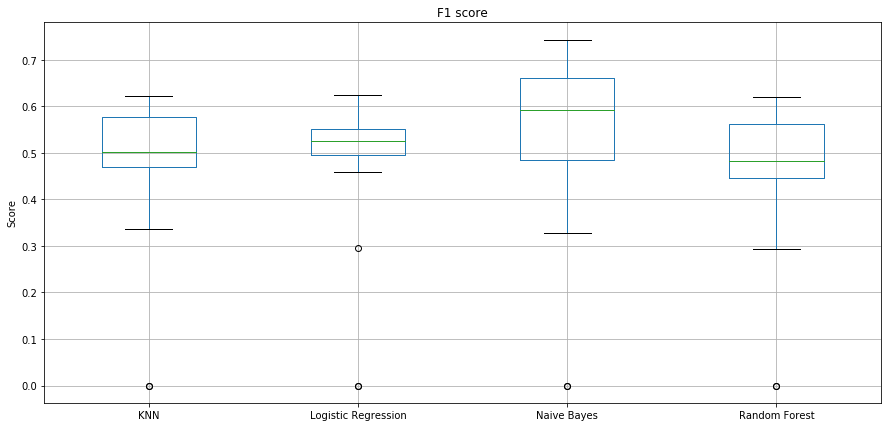

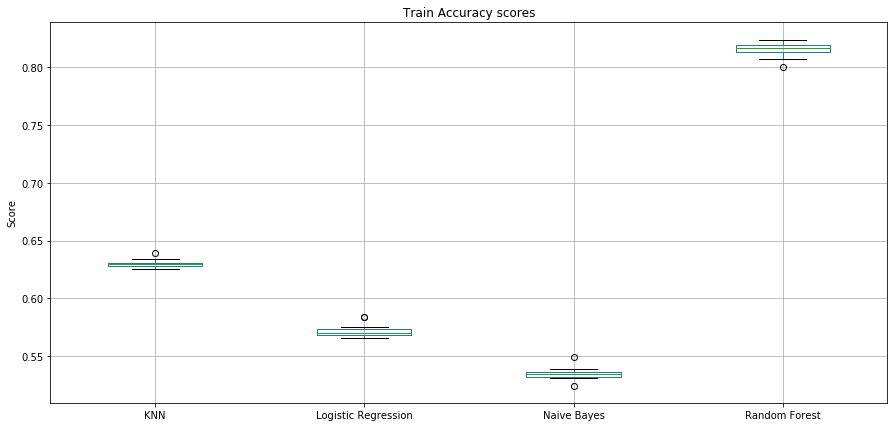

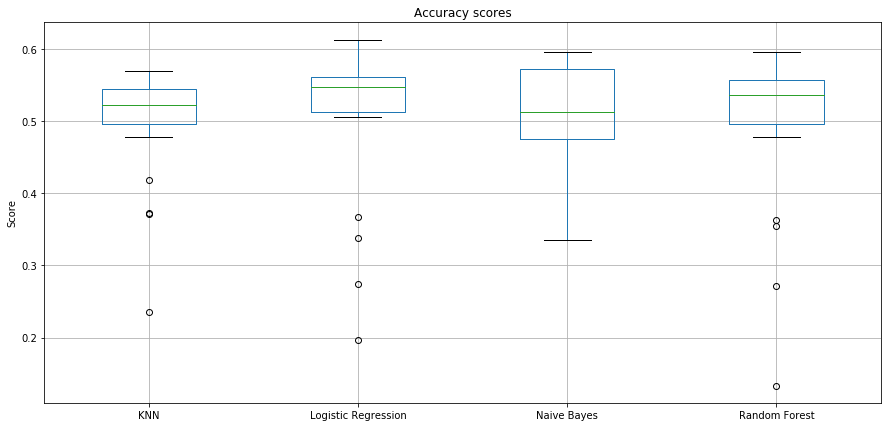

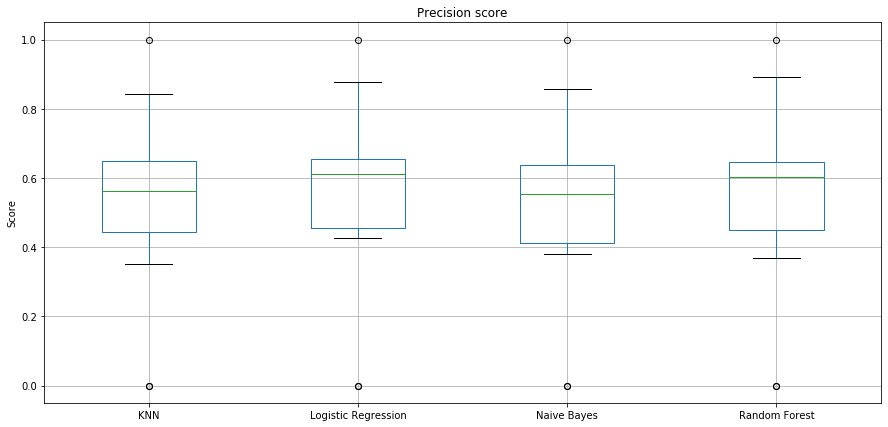

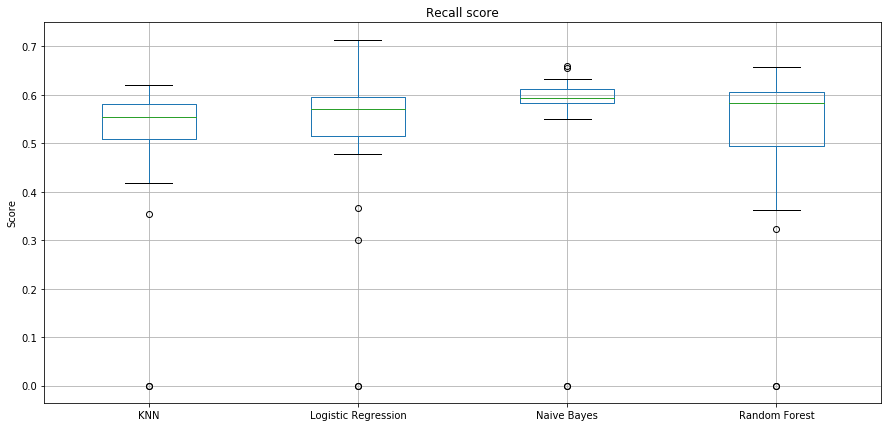

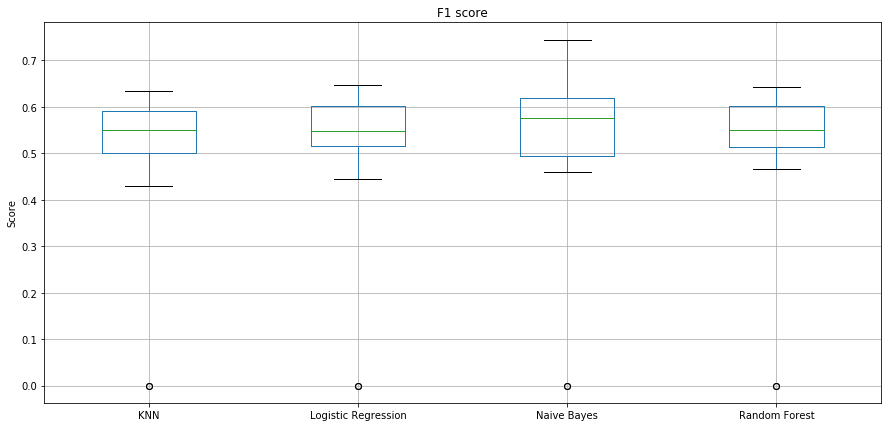

In [220]:
data_no_offence_stats = clean_data(data_no_offence_stats)
data = clean_data(data)

most_corr_features_no_offence = plot_correlation(data_no_offence_stats)
most_corr_features = plot_correlation(data)

data_no_offence_stats = structure_data(data_no_offence_stats)
data = structure_data(data)

print('*****TOP CORRELATED FEATURES ONLY********')
print('\nNo offence stats')
evaluate_models_best_params_no_offence(data_no_offence_stats.loc[:,most_corr_features_no_offence].copy())
print('\n\nOffence stats')
evaluate_models_best_params(data.loc[:,most_corr_features])